# CICERO SCM notebook - parallel application

Import some stuff

In [1]:
import sys
import re
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import pandas.testing as pdt
import warnings
import logging

try:
    from pandas.core.common import SettingWithCopyWarning
except:
    from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", message=".*Parameter.*")

In [20]:
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

In [3]:
import concurrent

In [4]:
from ciceroscm.parallel._configdistro import _ConfigDistro
from ciceroscm.parallel.calibrator import Calibrator
from ciceroscm.parallel.distributionrun import DistributionRun


/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman
/uio/kant/div-cicero-u1/bensan/ciceroscm-1/venv/lib/python3.8/site-packages/setuptools_scm/_integration/setuptools.py:31: RuntimeWarning: 
ERROR: setuptools==47.1.0 is used in combination with setuptools_scm>=8.x

Your build configuration is incomplete and previously worked by accident!
setuptools_scm requires setuptools>=61

Suggested workaround if applicable:
 - migrating from the deprecated setup_requires mechanism to pep517/518
   and using a pyproject.toml to declare build dependencies
   which are reliably pre-installed before running the build tools

  warnings.warn(


<IPython.core.display.Javascript object>

Import the model

In [5]:
sys.path.insert(0,os.path.join(os.getcwd(), '../', 'src'))
from ciceroscm import CICEROSCM

Define some input handling functions to give us example inputs

In [6]:
from ciceroscm.input_handler import read_inputfile,read_components,read_natural_emissions

Define a function to convert model output to a dataframe

set up input directories

In [7]:
test_data_dir = os.path.join(os.getcwd(), '../', 'tests', 'test-data')

# Read in datafiles into dataframes

In [8]:
# NBVAL_IGNORE_OUTPUT
#Read gas parameters
gaspam =read_components(test_data_dir + '/gases_v1RCMIP.txt')
gaspam.head()

,EM_UNIT,CONC_UNIT,BETA,ALPHA,TAU1,TAU2,TAU3,NAT_EM,SARF_TO_ERF
GAS,,,,,,,,,
CO2,Pg_C,ppm,2.123,0.00000,150.00,0,0,0.0,1.000000
CH4,Tg,ppb,2.780,0.00000,9.60,120,160,275.0,0.877193
N2O,Tg_N,ppb,4.810,0.00000,121.00,0,0,9.5,1.000000
SO2,Tg_S,-,11.000,0.00000,0.02,0,0,0.0,1.000000
CFC-11,Gg,ppt,22.600,0.00026,45.00,0,0,0.0,1.000000


Read natural emissions

In [9]:
# NBVAL_IGNORE_OUTPUT
df_nat_ch4 =read_natural_emissions(test_data_dir + '/natemis_ch4.txt','CH4')
df_nat_n2o =read_natural_emissions(test_data_dir + '/natemis_n2o.txt','N2O')
df_nat_ch4.head()


,CH4
year,
1750,269.4273
1751,270.9068
1752,273.0183
1753,272.0470
1754,271.1915


Read forcing

In [10]:
df_ssp2_conc =read_inputfile(test_data_dir + '/ssp245_conc_RCMIP.txt')
df_ssp2_conc.head()

,CO2,CH4,N2O,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,CH3Br,CCl4,...,HFC143a,HFC227ea,HFC23,HFC245fa,HFC32,HFC4310mee,C2F6,C6F14,CF4,SF6
Component,,,,,,,,,,,,,,,,,,,,,
1700,276.746000,706.054021,272.212049,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1701,276.749995,706.247004,272.243047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1702,276.757998,706.375031,272.266047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1703,276.757001,706.491002,272.298047,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0
1704,276.755000,706.602046,272.331052,0.0,0.0,0.0,0.0,0.0,5.299998,0.025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.049999,0.0


In [11]:
emi_input =read_inputfile(test_data_dir + '/ssp245_em_RCMIP.txt')
emi_input.rename(columns={"CO2": "CO2_FF", "CO2.1": "CO2_AFOLU"}, inplace=True)
emi_input.head()

,CO2_FF,CO2_AFOLU,CH4,N2O,SO2,CFC-11,CFC-12,CFC-113,CFC-114,CFC-115,...,CF4,SF6,NOx,CO,NMVOC,NH3,BMB_AEROS_BC,BMB_AEROS_OC,BC,OC
Component,,,,,,,,,,,,,,,,,,,,,
1750,0.002592,0.081127,19.019783,0.054710,1.222464,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.871504,348.527359,60.021826,6.927690,1.353250,12.520269,0.744520,2.927399
1751,0.002593,0.082619,18.915109,0.055744,1.206598,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828060,343.926367,59.088126,6.860142,1.335274,12.279280,0.737652,2.909437
1752,0.002594,0.084139,18.889712,0.056797,1.200955,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.828658,341.809034,58.631997,6.819482,1.326617,12.121816,0.737695,2.912659
1753,0.002594,0.085687,19.121377,0.057870,1.207757,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.812105,343.675456,59.026349,6.881439,1.328560,12.249330,0.743391,2.933215
1754,0.002595,0.087263,19.509061,0.058963,1.233495,0.0,0.0,0.0,0.0,0.0,...,0.010071,0.0,3.841598,349.815625,60.269945,7.015189,1.346553,12.593635,0.752796,2.965138


# Set up model run with defined input variables

In [172]:
scendata={
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":False,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
            "udir": test_data_dir,
            "scenname": "ssp245",
        }

In [173]:
    calibdata = pd.DataFrame(
        data={
            "Variable Name": [
                "Heat Content|Ocean",
                "Surface Air Ocean Blended Temperature Change",
            ],
            "Yearstart_norm": [1971, 1961],
            "Yearend_norm": [1971, 1990],
            "Yearstart_change": [2018, 2000],
            "Yearend_change": [2018, 2019],
            "Central Value": [320.69251537323, 0.5372],
            "sigma": [17.020342912051203, 0.039028311931729676],
        })

In [174]:
    testconfig = _ConfigDistro(
        distro_array=[],
        ordering=["aerosol_total", "W", "lambda", "beta_f"],
        setvalues={
            "threstemp": 7.0,
            "lm": 40,
            "ldtime": 12,
            "qbmb": 0,
            "qo3": 0.5,
            "qh2o_ch4": 0.091915,
            "rlamdo": 16,
            "akapa": 0.634,
            "cpi": 0.4,
            "beto": 3.5,
            "mixed": 60,
            "foan":0.61,
        },
        options={"aerosol_total": [-0.36, -0.97, 0.16, -0.08]}
    )

distro_array not 2 dimensional, disregarding


In [15]:
# NBVAL_IGNORE_OUTPUT
scen = 'test'
cscm_dir=CICEROSCM({
            "gaspam_data": gaspam,
            "emstart": 1750,  
            "conc_run":True,
            "nystart": 1750,
            "nyend": 2100,
            "concentrations_data": df_ssp2_conc,
            "emissions_data": emi_input,
            "nat_ch4_data": df_nat_ch4,
            "nat_n2o_data": df_nat_n2o,
            "idtm":24,
        })

In [16]:
distrorun1 = DistributionRun(testconfig, numvalues=10000)
output_vars = ["Heat Uptake", "Surface Air Temperature Change"]


[-3.          0.55        0.53908356  0.11      ]
[-0.5         2.55        1.34770889  0.465     ]


In [47]:
def get_results(cfg):
    cscm_dir._run({"results_as_dict": True},pamset_udm=cfg['pamset_udm'],pamset_emiconc=cfg['pamset_emiconc'])
    return [cfg,cscm_dir.results]

In [48]:
def run_parallel(cfgs,nworkers=4):
    results=len(cfgs)*[None]
    with ProcessPoolExecutor(nworkers) as exe:
            # execute tasks concurrently and process results in order
            pres=list(tqdm(exe.map(get_results, cfgs)))
            for result in pres:
                # get the corresponding index of the config
                ind=int(result[0]['Index'])
                # put it in the right element of the results vector
                results[ind]=result[1]
    return results

In [53]:
results=run_parallel(distrorun1.cfgs,nworkers=100)

10000it [03:57, 42.05it/s]


In [54]:
flds=['dT_glob','OHCTOT','concentrations-CO2','RIB_glob']

In [55]:
def to_df(rs):

    out=pd.concat([pd.DataFrame(v).reset_index(drop=True) for k, v in rs.items()], keys = rs.keys(),axis=1) 
    out.index=rs['forcing'].index
    return out

In [56]:
def make_ensdf(results,flds):
    resdf=[]
    for i,res in enumerate(results):
        df=to_df(res)
        test_list=df.columns.map('{0[0]}-{0[1]}'.format).tolist()
        df.columns=[sub.replace('-0', '') for sub in test_list]
        resdf.append(df[flds].unstack())
    ensdf=pd.concat(resdf,axis=1)
    return ensdf

In [66]:
df=make_ensdf(results,flds)

In [77]:
df.index.names = ['variable', 'year']
df.columns.names=['run_id']

In [78]:
df

run_id             0         1         2         3         4         5     \
variable year                                                               
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000050  0.000032  0.000032  0.000031  0.000026  0.000046   
         1752  0.000249  0.000182  0.000184  0.000171  0.000160  0.000225   
         1753  0.000560  0.000454  0.000464  0.000412  0.000424  0.000492   
         1754  0.000867  0.000775  0.000802  0.000685  0.000760  0.000742   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  1.661271  1.447630  1.710308  0.977733  1.523356  1.047405   
         2097  1.650241  1.437729  1.700003  0.969464  1.513585  1.038086   
         2098  1.639281  1.427835  1.689664  0.961263  1.503774  1.028929   
         2099  1.628352  1.417914  1.679260  0.953094  1.493894  1.019886   
         2100  1.617447  1.407966  1.668792  0.944954  1.483947  1.010943   

run_id             6         7         8         9     ...      9990  \
variable year                                          ...             
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  ...  0.000000   
         1751  0.000023  0.000041  0.000025  0.000032  ...  0.000035   
         1752  0.000146  0.000219  0.000150  0.000178  ...  0.000195   
         1753  0.000391  0.000519  0.000388  0.000434  ...  0.000484   
         1754  0.000705  0.000850  0.000683  0.000726  ...  0.000822   
...                 ...       ...       ...       ...  ...       ...   
RIB_glob 2096  1.204551  1.777235  1.052825  1.144356  ...  1.767212   
         2097  1.195718  1.766569  1.044498  1.135410  ...  1.756751   
         2098  1.186871  1.755904  1.036186  1.126514  ...  1.746259   
         2099  1.177981  1.745205  1.027861  1.117635  ...  1.735707   
         2100  1.169050  1.734469  1.019521  1.108769  ...  1.725094   

run_id             9991      9992      9993      9994      9995      9996  \
variable year                                                               
dT_glob  1750  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
         1751  0.000034  0.000035  0.000033  0.000031  0.000043  0.000042   
         1752  0.000183  0.000191  0.000187  0.000172  0.000217  0.000219   
         1753  0.000440  0.000459  0.000474  0.000416  0.000496  0.000511   
         1754  0.000727  0.000759  0.000819  0.000691  0.000781  0.000824   
...                 ...       ...       ...       ...       ...       ...   
RIB_glob 2096  1.141926  1.277104  1.821902  1.008223  1.267582  1.546678   
         2097  1.132811  1.267494  1.811510  0.999761  1.257639  1.536164   
         2098  1.123759  1.257935  1.801068  0.991364  1.247795  1.525695   
         2099  1.114734  1.248390  1.790547  0.982996  1.238009  1.515236   
         2100  1.105731  1.238857  1.779947  0.974654  1.228273  1.504779   

run_id             9997      9998      9999  
variable year                                
dT_glob  1750  0.000000  0.000000  0.000000  
         1751  0.000043  0.000039  0.000047  
         1752  0.000220  0.000209  0.000233  
         1753  0.000506  0.000494  0.000515  
         1754  0.000801  0.000805  0.000784  
...                 ...       ...       ...  
RIB_glob 2096  1.388646  1.488441  1.200530  
         2097  1.378372  1.478128  1.190609  
         2098  1.368180  1.467856  1.180829  
         2099  1.358029  1.457589  1.171145  
         2100  1.347912  1.447323  1.161545  

[1404 rows x 10000 columns]

In [69]:
def plot_range(df, var, ax,col='k'):
    Tdf=df.xs(var).T
    lower = Tdf.quantile(0.10)
    upper = Tdf.quantile(0.90)
    ax.fill_between(Tdf.columns, lower, upper, color=col, alpha=0.2,edgecolor=None)
    ax.plot(Tdf.columns, Tdf.mean(), color=col)



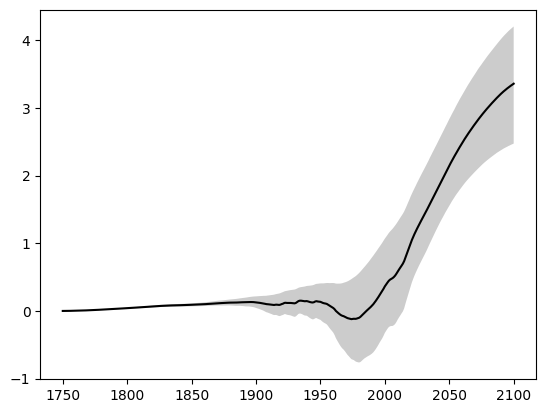

In [70]:
plot_range(df, 'dT_glob', plt.gca())

variable   dT_glob                                             OHCTOT  \
year          1950      1970      1990      2005      2018       1950   
run_id                                                                  
0        -0.182018 -0.754281 -0.817065 -0.380271  0.123797  -3.191026   
1         0.251701  0.128870  0.385850  0.785749  1.195488  18.225267   
2         0.326647  0.226037  0.523712  0.972159  1.430998  22.814180   
3         0.142114  0.013658  0.207538  0.504495  0.810839  11.150709   
4         0.447951  0.496377  0.889304  1.304123  1.708832  28.421234   
...            ...       ...       ...       ...       ...        ...   
9995     -0.043128 -0.415516 -0.349376  0.024657  0.434924   2.598662   
9996      0.020037 -0.341834 -0.251909  0.168164  0.627708   6.737494   
9997     -0.034650 -0.420485 -0.357163  0.037643  0.471753   3.431050   
9998      0.075759 -0.222610 -0.090199  0.319514  0.760208   9.385339   
9999     -0.156804 -0.628483 -0.630400 -0.261829  0.153069  -3.431394   

variable                                             concentrations-CO2  \
year           1970       1990       2005       2018               1950   
run_id                                                                    
0        -21.879541 -38.476478 -33.161369 -21.070702         312.820976   
1         17.329511  23.834871  39.308584  57.368257         312.820976   
2         23.388631  32.114254  50.160436  71.097165         312.820976   
3          8.894770  12.753110  23.816290  36.666913         312.820976   
4         34.640461  50.553023  71.079391  92.896500         312.820976   
...             ...        ...        ...        ...                ...   
9995      -8.737998 -15.702064  -7.555339   4.810088         312.820976   
9996      -3.606287  -9.291291   0.831380  15.712144         312.820976   
9997      -8.230646 -15.589028  -7.000819   6.188949         312.820976   
9998       1.478962  -1.052802  10.310221  25.784845         312.820976   
9999     -18.830081 -30.868606 -25.375781 -15.065568         312.820976   

variable                                                  RIB_glob            \
year            1970        1990        2005        2018      1950      1970   
run_id                                                                         
0         324.782956  354.072932  378.907008  408.631966 -0.279478 -0.914683   
1         324.782956  354.072932  378.907008  408.631966  0.069012 -0.061317   
2         324.782956  354.072932  378.907008  408.631966  0.112909 -0.002970   
3         324.782956  354.072932  378.907008  408.631966  0.009901 -0.111861   
4         324.782956  354.072932  378.907008  408.631966  0.217463  0.273797   
...              ...         ...         ...         ...       ...       ...   
9995      324.782956  354.072932  378.907008  408.631966 -0.158011 -0.563454   
9996      324.782956  354.072932  378.907008  408.631966 -0.117443 -0.516037   
9997      324.782956  354.072932  378.907008  408.631966 -0.155226 -0.578571   
9998      324.782956  354.072932  378.907008  408.631966 -0.071438 -0.398405   
9999      324.782956  354.072932  378.907008  408.631966 -0.249483 -0.765833   

variable                                
year          1990      2005      2018  
run_id                                  
0        -0.160198  0.196603  1.236176  
1         0.496093  0.703999  1.253937  
2         0.585193  0.830929  1.394589  
3         0.363893  0.485530  0.980719  
4         0.778664  0.956704  1.340417  
...            ...       ...       ...  
9995      0.084631  0.314755  1.124836  
9996      0.149096  0.432451  1.245131  
9997      0.085919  0.344562  1.175390  
9998      0.236132  0.493643  1.234869  
9999     -0.071694  0.162030  1.088037  

[10000 rows x 20 columns]

In [96]:
dates=[1950,1970,1990,2005,2018]
targ=df.loc[(slice(None), dates), :].T
nflds=targ.shape[1]


In [97]:
def merge_dicts(dc):
    """Given two dictionaries, merge them into a new dict as a shallow copy."""
    x=dc['pamset_udm']
    y=dc['pamset_emiconc']
    z = x.copy()
    z.update(y)
    return z

In [98]:
pdict=distrorun1.cfgs
mdict=[ merge_dicts(d) for d in pdict ]
pmat=pd.DataFrame(mdict)

In [102]:
parammat=pmat.loc[:, (pmat != pmat.iloc[0]).any()].drop(columns=['emstart','nystart','nyend','lifetime_mode'])
parammat

,W,lambda,qdirso2,qindso2,qbc,qoc,beta_f
0,0.953046,1.074141,-0.829458,-2.234928,0.368648,-0.184324,0.439706
1,1.625612,0.954525,-0.383640,-1.033696,0.170506,-0.085253,0.427303
2,0.718206,1.204982,-0.354389,-0.954881,0.157506,-0.078753,0.421672
3,2.057238,0.572958,-0.426285,-1.148601,0.189460,-0.094730,0.151083
4,1.695335,1.051478,-0.206382,-0.556086,0.091726,-0.045863,0.337113
...,...,...,...,...,...,...,...
9995,1.207078,0.759604,-0.695910,-1.875090,0.309293,-0.154647,0.361095
9996,1.613759,1.003342,-0.628997,-1.694798,0.279554,-0.139777,0.211601
9997,0.685988,0.857267,-0.684991,-1.845670,0.304440,-0.152220,0.239762
9998,1.330477,0.961323,-0.569199,-1.533676,0.252977,-0.126489,0.377197


In [106]:
targ

variable   dT_glob                                             OHCTOT  \
year          1950      1970      1990      2005      2018       1950   
run_id                                                                  
0        -0.182018 -0.754281 -0.817065 -0.380271  0.123797  -3.191026   
1         0.251701  0.128870  0.385850  0.785749  1.195488  18.225267   
2         0.326647  0.226037  0.523712  0.972159  1.430998  22.814180   
3         0.142114  0.013658  0.207538  0.504495  0.810839  11.150709   
4         0.447951  0.496377  0.889304  1.304123  1.708832  28.421234   
...            ...       ...       ...       ...       ...        ...   
9995     -0.043128 -0.415516 -0.349376  0.024657  0.434924   2.598662   
9996      0.020037 -0.341834 -0.251909  0.168164  0.627708   6.737494   
9997     -0.034650 -0.420485 -0.357163  0.037643  0.471753   3.431050   
9998      0.075759 -0.222610 -0.090199  0.319514  0.760208   9.385339   
9999     -0.156804 -0.628483 -0.630400 -0.261829  0.153069  -3.431394   

variable                                             concentrations-CO2  \
year           1970       1990       2005       2018               1950   
run_id                                                                    
0        -21.879541 -38.476478 -33.161369 -21.070702         312.820976   
1         17.329511  23.834871  39.308584  57.368257         312.820976   
2         23.388631  32.114254  50.160436  71.097165         312.820976   
3          8.894770  12.753110  23.816290  36.666913         312.820976   
4         34.640461  50.553023  71.079391  92.896500         312.820976   
...             ...        ...        ...        ...                ...   
9995      -8.737998 -15.702064  -7.555339   4.810088         312.820976   
9996      -3.606287  -9.291291   0.831380  15.712144         312.820976   
9997      -8.230646 -15.589028  -7.000819   6.188949         312.820976   
9998       1.478962  -1.052802  10.310221  25.784845         312.820976   
9999     -18.830081 -30.868606 -25.375781 -15.065568         312.820976   

variable                                                  RIB_glob            \
year            1970        1990        2005        2018      1950      1970   
run_id                                                                         
0         324.782956  354.072932  378.907008  408.631966 -0.279478 -0.914683   
1         324.782956  354.072932  378.907008  408.631966  0.069012 -0.061317   
2         324.782956  354.072932  378.907008  408.631966  0.112909 -0.002970   
3         324.782956  354.072932  378.907008  408.631966  0.009901 -0.111861   
4         324.782956  354.072932  378.907008  408.631966  0.217463  0.273797   
...              ...         ...         ...         ...       ...       ...   
9995      324.782956  354.072932  378.907008  408.631966 -0.158011 -0.563454   
9996      324.782956  354.072932  378.907008  408.631966 -0.117443 -0.516037   
9997      324.782956  354.072932  378.907008  408.631966 -0.155226 -0.578571   
9998      324.782956  354.072932  378.907008  408.631966 -0.071438 -0.398405   
9999      324.782956  354.072932  378.907008  408.631966 -0.249483 -0.765833   

variable                                
year          1990      2005      2018  
run_id                                  
0        -0.160198  0.196603  1.236176  
1         0.496093  0.703999  1.253937  
2         0.585193  0.830929  1.394589  
3         0.363893  0.485530  0.980719  
4         0.778664  0.956704  1.340417  
...            ...       ...       ...  
9995      0.084631  0.314755  1.124836  
9996      0.149096  0.432451  1.245131  
9997      0.085919  0.344562  1.175390  
9998      0.236132  0.493643  1.234869  
9999     -0.071694  0.162030  1.088037  

[10000 rows x 20 columns]

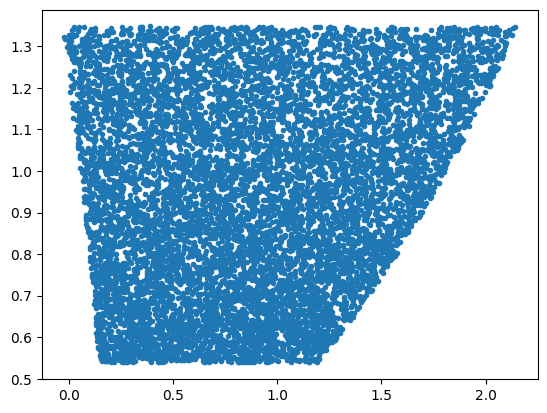

In [108]:
plt.plot(targ['dT_glob'][2018],pmat['lambda'],'.')

In [109]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building


In [125]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2024-05-10 00:43:57.451963: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 00:43:57.587389: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-10 00:43:57.593888: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-05-10 00:44:05.563457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [156]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(30, activation='tanh'),
      layers.Dense(10, activation='tanh'),

      layers.Dense(nflds)
  ])

  model.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [157]:
normalizer = tf.keras.layers.Normalization(input_shape=[parammat.shape[1],], axis=-1)

In [158]:
parammat

,W,lambda,qdirso2,qindso2,qbc,qoc,beta_f
0,0.953046,1.074141,-0.829458,-2.234928,0.368648,-0.184324,0.439706
1,1.625612,0.954525,-0.383640,-1.033696,0.170506,-0.085253,0.427303
2,0.718206,1.204982,-0.354389,-0.954881,0.157506,-0.078753,0.421672
3,2.057238,0.572958,-0.426285,-1.148601,0.189460,-0.094730,0.151083
4,1.695335,1.051478,-0.206382,-0.556086,0.091726,-0.045863,0.337113
...,...,...,...,...,...,...,...
9995,1.207078,0.759604,-0.695910,-1.875090,0.309293,-0.154647,0.361095
9996,1.613759,1.003342,-0.628997,-1.694798,0.279554,-0.139777,0.211601
9997,0.685988,0.857267,-0.684991,-1.845670,0.304440,-0.152220,0.239762
9998,1.330477,0.961323,-0.569199,-1.533676,0.252977,-0.126489,0.377197


In [159]:
normalizer.adapt(parammat)

In [160]:
dnn_model = build_and_compile_model(normalizer)


In [161]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [162]:
from tqdm.keras import TqdmCallback

In [163]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


In [165]:
history=dnn_model.fit(X_train, Y_train, epochs=10000, batch_size=100, validation_data=(X_dev, Y_dev),verbose=0,callbacks=[TqdmCallback(verbose=0)])


0epoch [00:00, ?epoch/s]

KeyboardInterrupt: 

In [166]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

282/282 [==============================] - 1s 2ms/step


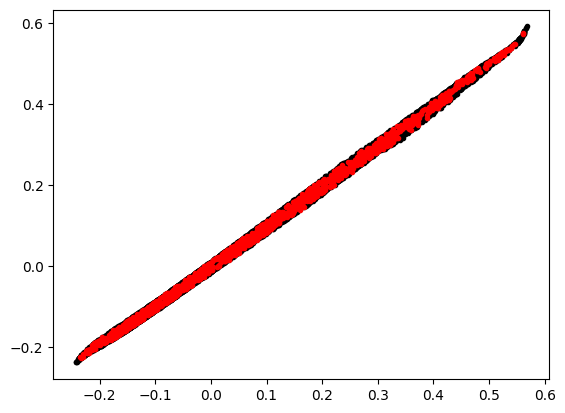

In [167]:
plt.plot(pred_t[:,0],Y_train[:,0],'k.')
plt.plot(pred[:,0],Y_dev[:,0],'r.')

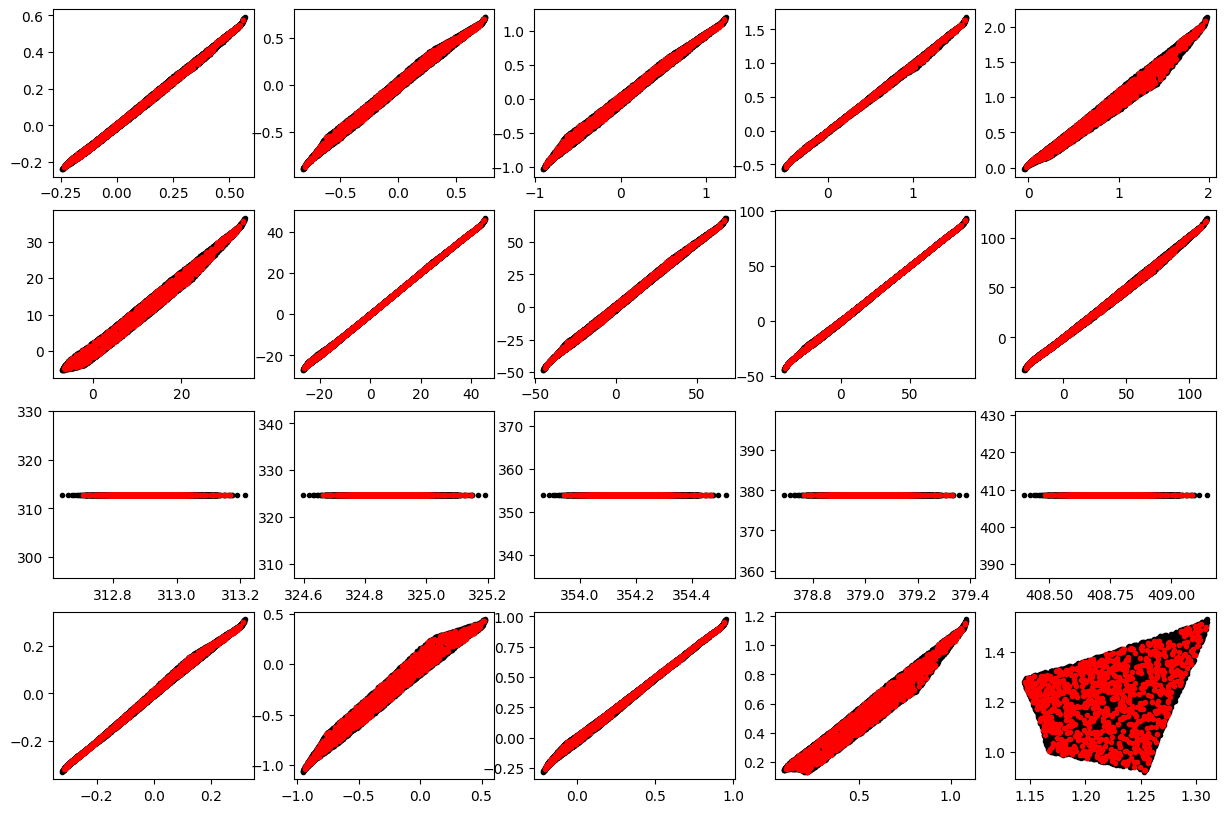

In [171]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'k.')
  ax[i].plot(pred[:,i],Y_dev[:,i],'r.')

